<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w3d4_t2_fixes/tutorials/W3D4_ContinualLearning/W3D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Out-of-distribution (OOD) Learning

**Week 3, Day 4: Continual Learning**

**By Neuromatch Academy**

__Content creators:__  Avishree Khare, Het Shah, Joshua Vogelstein

__Content reviewers:__ Arush Tagade, Jeremy Forest, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni, Spiros Chavlis

__Production editors:__ Deepak Raya, Spiros Chavlis
 



**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

Deep Learning has seen tremendous growth in recent years thanks to more data, more compute and *very* deep neural networks. Although these networks perform extremely well on the specified task, they fail to generalize to newer tasks. 

In this tutorial, we will explore Out-of-distribution (OOD) Learning and the several OOD paradigms that have been gaining popularity in recent years. We will understand what OOD really means and how it is different from anything else that we've looked at so far. We'll also take a look at Transfer Learning, Multi-task Learning and Meta-Learning which aim to facilitate OOD Learning in different ways. Here is a list of topics that we would be covering in this tutorial:

1. Introduction to OOD Learning
2. Transfer Learning
3. Multi-Task Learning
4. Meta-Learning

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/dqnm6/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/dqnm6/download).

---
# Setup

In [2]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install pandas --quiet
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W3D4_T2','https://portal.neuromatchacademy.org/api/redirect/to/1d7fcd5d-f1e9-4ac5-ae58-b0ade54a4f87')

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:22tcmalloc: large alloc 1147494400 bytes == 0x55b365bf8000 @  0x7fe9bda72615 0x55b32c4ed4cc 0x55b32c5cd47a 0x55b32c4f02ed 0x55b32c5e1e1d 0x55b32c563e99 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c563d00 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c560737 0x55b32c5e2c66 0x55b32c55fdaf 0x55b32c5e2c66 0x55b32c55fdaf 0x55b32c5e2c66 0x55b32c55fdaf 0x55b32c4f2039 0x55b32c535409 0x55b32c4f0c52 0x55b32c563c25 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c560737 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c55f915 0x55b32c4f1afa 0x55b32c55fc0d 0x55b32c55e9ee
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:33tcmalloc: large alloc 1434370048 bytes == 0x55b3aa24e000 @  0x7fe9bda72615 0x55b32c4ed4cc 0x55b32c5cd47a 0x55b32c4f02ed 0x55b32c5e1e1d 0x55b32c563e99 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c563d00 0x55b32c55e9ee 0x55b32c4f1bda 0x55b32c560737 0x55b32c5e2c66 0x55b32c55fd

In [3]:
# Imports
import os
import copy
import time
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.datasets import CelebA, Omniglot
from torchvision import datasets, models, transforms

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def visualize_siamese_sample(sample):
  to_PIL = transforms.ToPILImage()
  fig, axs = plt.subplots(1, 2, figsize=(8, 10))
  x1, x2, y = sample
  label = y.item()
  similarity = "Same character" if label == 1.0 else "Different characters"
  print(f"-------------------- Label: {label} ({similarity}) -------------------")
  axs[0].imshow(to_PIL(x1), cmap='gray')
  axs[1].imshow(to_PIL(x2), cmap='gray')
  # axs[0].set_title(f'Label: {label} ({similarity})')

  for i in range(2):
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])

  plt.tight_layout()
  plt.show()


def visualize_mtfl_sample(sample):
  to_PIL = transforms.ToPILImage()
  img, labels = sample

  fig, ax = plt.subplots()
  ax.xaxis.set_ticks([])
  ax.yaxis.set_ticks([])
  print(f"Labels: {labels.tolist()}")
  ax.imshow(to_PIL(img))
  plt.show()


def visualize_one_shot_sample(sample):
  to_PIL = transforms.ToPILImage()
  query_img, support_imgs, support_labels, similarity = sample
  n_rows = 1
  n_cols = len(support_imgs) + 1
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, 10))

  axs[0].imshow(to_PIL(query_img), cmap='gray')
  axs[0].set_title('Query Image')
  axs[0].xaxis.set_ticks([])
  axs[0].yaxis.set_ticks([])

  for i, (s_img, s_label) in enumerate(zip(support_imgs, support_labels)):
    axs[i+1].imshow(to_PIL(s_img), cmap='gray')
    label = s_label.item()
    similarity = "Same character" if label == 1.0 else "Different characters"
    axs[i+1].set_title(f"Support Image {i+1} \n "
                       f"Label: {s_label.item()} ({similarity})")
    axs[i+1].xaxis.set_ticks([])
    axs[i+1].yaxis.set_ticks([])

  plt.tight_layout()
  plt.show()

In [6]:
# @title Dataset Definitions and Helper Functions

# @markdown `pandas` and `PIL` libraries should be installed.
import pandas as pd
from PIL import Image

"""
Datasets for N-way 1-shot classification on the Omniglot Dataset
"""

class SiameseOmniglotDataset(Dataset):
  def __init__(self, num_samples=10000,
               data_transforms=transforms.ToTensor(), download=True):
    self.dataset = Omniglot(root='./data/',
                            background=True,
                            download=download,
                            transform=data_transforms)
    self.num_samples = num_samples
    self.num_classes = len(self.dataset._characters)
    self.classes = range(self.num_classes)
    self.instances_per_class = dict()
    self.get_instances_per_class()

  def __getitem__(self, idx):
    if idx % 2 == 0:
      return self.get_instances_from_same_class()
    return self.get_instances_from_diff_classes()

  def get_instances_from_same_class(self):
    c = random.randint(0, self.num_classes-1)
    [ch_1, ch_2] = random.sample(self.instances_per_class[c], 2)
    return ch_1, ch_2, torch.tensor([1.0])

  def get_instances_from_diff_classes(self):
    [c1, c2] = random.sample(self.classes, 2)
    [ch_1] = random.sample(self.instances_per_class[c1], 1)
    [ch_2] = random.sample(self.instances_per_class[c2], 1)
    return ch_1, ch_2, torch.tensor([0.0])

  def get_random_instance(self):
    ids = np.random.randint(0, len(self.dataset), 2)
    character_1 = self.dataset[ids[0]][0]
    character_2 = self.dataset[ids[1]][0]
    label_1 = self.dataset[ids[0]][1]
    label_2 = self.dataset[ids[1]][1]
    similarity = torch.tensor([label_1 == label_2], dtype=torch.float)
    return character_1, character_2, similarity

  def __len__(self):
    return self.num_samples

  def get_instances_per_class(self):
    for (image, label) in self.dataset:
      if label in self.instances_per_class:
        self.instances_per_class[label].append(image)
      else:
        self.instances_per_class[label] = [image]


class NWayOneShotOmniglotDataset(Dataset):
  def __init__(self, data_transforms=transforms.ToTensor(), n_ways=5,
               download=True):
    self.dataset = Omniglot(root='./data/',
                            background=False,
                            download=download,
                            transform=data_transforms)
    self.size = len(self.dataset)
    self.num_classes = len(self.dataset._characters)
    self.classes = range(self.num_classes)
    self.n_ways = n_ways
    self.instances_per_class = dict()
    self.get_instances_per_class()

  def __getitem__(self, idx):
    query_img, query_class = self.dataset[idx]

    # Find (n_ways - 1) distinct characters different from query_class
    support_imgs = []
    support_labels = []
    support_classes = random.sample([c for c in self.classes if c != query_class], self.n_ways-1)

    # Find 1 support image from query_class
    support_classes.append(query_class)

    random.shuffle(support_classes)

    for c in support_classes:
      [img] = random.sample(self.instances_per_class[c], 1)
      support_imgs.append(img)
      support_labels.append(torch.tensor([c == query_class], dtype=torch.float))

    _, similarity = torch.max(torch.tensor(support_labels), axis=0)
    return query_img, support_imgs, support_labels, similarity

  def __len__(self):
    return self.size

  def get_instances_per_class(self):
    for (image, label) in self.dataset:
      if label in self.instances_per_class:
        self.instances_per_class[label].append(image)
      else:
        self.instances_per_class[label] = [image]


class MTFLDataset(Dataset):
  def __init__(self, data_file,
               num_samples=10000,
               data_transforms=transforms.ToTensor(), ):

    self.df = pd.read_csv(data_file, sep=' ', header=None,
                          skipinitialspace=True, nrows=num_samples)
    self.df.iloc[:, 0] = self.df.iloc[:, 0].apply(lambda s: s.replace('\\', '/'))
    self.transform = data_transforms

  def __getitem__(self, idx):
    item = self.df.iloc[idx]
    img_name = item[0]
    labels = (item[11:] - 1)  # 1-indexed to 0-indexed

    img = Image.open(img_name)
    img = self.transform(img)

    return img, torch.from_numpy(np.array(labels, dtype=np.float32)).long()

  def __len__(self):
    return len(self.df)


"""
Load datasets
"""

def get_train_val_datasets(background_dataset_size=10000,
                           val_split=0.2, download=True):

  dataset_size = background_dataset_size
  val_split = 0.2
  train_size = int(dataset_size * (1 - val_split))
  val_size = dataset_size - train_size

  background_dataset = SiameseOmniglotDataset(num_samples=dataset_size,
                                              download=download)
  train_dataset, val_dataset = random_split(background_dataset, [train_size, val_size])

  return train_dataset, val_dataset


def get_test_dataset(n_ways=5, download=True):
  return NWayOneShotOmniglotDataset(n_ways=n_ways, download=download)


def get_train_val_datasets_mtfl(dirname, dataset_size=10000, val_split=0.2):

  data_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.ToTensor()])

  train_size = int(dataset_size * (1 - val_split))
  val_size = dataset_size - train_size

  background_dataset = MTFLDataset(data_file=f'{dirname}/MTFL/training.txt',
                                   num_samples=dataset_size,
                                   data_transforms=data_transforms)

  train_dataset, val_dataset = random_split(background_dataset, [train_size, val_size])

  return train_dataset, val_dataset

In [7]:
# @title Training/Evaluation Helper Functions

# @markdown `train_multi_task(model, trainloader, valloader, criterion, optimizer, epochs=10, device='cpu')`
def train_multi_task(model, trainloader, valloader, criterion, optimizer,
                     epochs=10, device='cpu'):

  best_model_weights = copy.deepcopy(model.state_dict())
  best_overall_acc = 0.0

  for ep in range(epochs):
    print("")
    print("======== Epoch {:} / {:} ========".format(ep + 1, epochs))

    running_corrects = np.zeros(4)
    running_loss = 0.0
    model.train()
    model.to(device)
    for inps, labels in trainloader:
      inps = inps.to(device)
      labels = labels.to(device)
      outs = model(inps)
      overall_loss = 0.0

      for i in range(4):
        overall_loss += criterion(outs[i].to(device), labels[:, i].to(device))
        _, preds = torch.max(outs[i], 1)
        running_corrects[i] += torch.sum(preds == labels[:, i].data)

      running_loss += overall_loss.item()

      optimizer.zero_grad()
      overall_loss.backward()
      optimizer.step()

    train_loss = running_loss/(len(trainloader) * inps.size(0))
    train_accs = running_corrects / (len(trainloader) * inps.size(0))
    train_overall_acc = np.mean(train_accs)
    running_corrects_val = np.zeros(4)

    model.eval()
    with torch.no_grad():
      for inps, labels in valloader:
        inps = inps.to(device)
        labels = labels.to(device)
        outs = model(inps)

        overall_loss = 0.0

        for i in range(4):
          _, preds = torch.max(outs[i], 1)
          running_corrects_val[i] += torch.sum(preds == labels[:, i].data)

      val_accs = running_corrects_val / (len(valloader) * inps.size(0))

      val_overall_acc = np.mean(val_accs)

      if val_overall_acc > best_overall_acc:
        best_overall_acc = val_overall_acc
        best_model_weights = copy.deepcopy(model.state_dict())

    print(f"Training => Avg. Task Accuracy: {train_overall_acc}")
    print(f"Validation => Avg. Task Accuracy: {val_overall_acc}")

  model.load_state_dict(best_model_weights)
  return model


# @markdown `train_siamese_network(model, criterion, optimizer, train_loader, device='cpu', print_freq=100)`
def train_siamese_network(model, criterion, optimizer, train_loader,
                          device="cpu", print_freq=100):
  model.to(device)
  running_loss = 0.0
  correct = 0.0
  total = 0.0
  for batch_idx, data in enumerate(train_loader):
    x1 = data[0].to(device)
    x2 = data[1].to(device)
    y = data[2].to(device)

    optimizer.zero_grad() #Set parameter gradients to zero

    y_pred = model(x1, x2)
    # print(y_pred.shape, y.shape)
    loss = criterion(y_pred.view(-1), y.view(-1))
    loss.backward() #Set the values for gradients (`grad`) of all the parameters
    optimizer.step() #Update the parameter values using the computed gradients

    running_loss += loss.item()

    y_out = torch.round(torch.sigmoid(y_pred)) #To do: do necessary modifs from sigmoid to regular
    correct += y_out.eq(y.to(device)).sum()
    total += y_out.shape[0]

    # if (batch_idx % print_freq) == (print_freq - 1):
    #   print(f"Batch: {batch_idx} Running loss: {running_loss / print_freq} Train accuracy: {acc}")
    #   running_loss = 0.0

  print(f"Training => Average Loss: {running_loss/len(train_loader)} | Accuracy: {correct/total}")


# @markdown `evaluate_siamese_network(model, criterion, val_loader, device='cpu')`
def evaluate_siamese_network(model, criterion, val_loader, device='cpu'):
  model.eval()
  model.to(device)
  correct = 0.0
  total = 0.0
  val_loss = 0.0
  with torch.no_grad():
    for (x1, x2, y) in val_loader:
      y_pred = model(x1.to(device), x2.to(device))
      loss = criterion(y_pred.view(-1), y.to(device).view(-1))
      val_loss += loss.item()
      y_out = torch.round(torch.sigmoid(y_pred)) #To do: do necessary modifs from sigmoid to regular
      correct += y_out.eq(y.to(device)).sum()
      total += y_out.shape[0]

  val_acc = correct/total
  val_loss = val_loss/len(val_loader)

  print(f"Validation => Average Loss: {val_loss} | Accuracy: {val_acc}")

def evaluate_one_shot(model, test_loader, device='cpu'):
  model.eval()
  model.to(device)

  correct = 0.0
  total = 0.0

  with torch.no_grad():
    for (query_img, support_imgs, support_labels, similarity) in test_loader:
      x_query = query_img.to(device)
      y_pred_fc = [model(x_query, x_support.to(device)) for x_support in support_imgs]
      y_pred = [torch.sigmoid(pred) for pred in y_pred_fc]
      _, y_out = torch.max(torch.cat(y_pred, dim=1), 1)
      correct += y_out.eq(similarity.to(device)).sum()
      total += y_out.shape[0]

  print(f'Testing (One-shot) => Accuracy: {correct/total}')

In [8]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [9]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [10]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Introduction to Out-of-Distribution (OOD) Learning

*Time estimate: ~5mins*

In this section, we'll take a brief look at what OOD Learning is and how it can be useful in solving various problems with traditional Deep Learning.

In [11]:
# @title Video 1: The Future of Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1764y167fj", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"zMQySpHBoGs", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: The Future of Learning')

display(out)

## Think! 1.1: What are the problems that *you* want to solve?

Think of a problem that you would want to have solved using Deep Learning. Don't restrict yourself to the problems you have looked at so far! 

Take 2 mins to think in silence and jot down a brief description of the problem here.

In [12]:
# @markdown
Problem_that_you_want_to_solve = '' # @param {type:"string"}

Now discuss the following as a group:

1. Can these problems be solved using the techniques that you have looked at so far? If not, why?
2. Is there an OOD element attached to any of the problems, which makes them harder to solve? 
3. Can you think of ways you could solve these problems? (Don't worry if you struggle, we'll hopefully find some suggestions by the end of this tutorial)

---
# Section 2: Transfer and Multi-Task Learning

*Time estimate: ~35mins*

In this tutorial we will learn transfer learning and multi-task learning. Transfer learning is a machine learning method where a model which is trained on a task (or dataset) can be used as a good initialization for training on a completely different and unrelated task (or dataset). Transfer learning is a very commonly used practice in a lot of Deep Learning works. This method is not limited to any particular subdomain and is widely used in almost all the domains, namely Computer Vision, Natural Language Processing, Reinforcement Learning, etc. 

Multi-task learning aims to learn multiple tasks simultaneously using shared knowledge across these tasks. We can use Transfer learning to initialize the shared parts of the network. 

We aim to learn these concepts via a simple problem of attributes classification for the celebA dataset. 

In [13]:
# @title Video 2: Transfer and Multi-Tasking Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV18w41197o8", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"PplDj0vXuIY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Transfer and Multi-Tasking Learning')

display(out)

## Section 2.1: Getting the data
We will be using the [MTFL](http://mmlab.ie.cuhk.edu.hk/projects/TCDCN.html) dataset for demonstrating the concepts of Transfer and Multi-Task Learning. 

In [14]:
# @title Get the current working directory in `CWD` variable.
CWD = os.getcwd()
print(f'Current dir: {CWD}')

Current dir: /content


In [15]:
# @title Download and unzip the dataset
import requests, zipfile

# originally from 'http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip'
os.chdir(CWD)
name = 'MTFL'
fname = f"{name}.zip"
url = "https://osf.io/u5emj/download"

if not os.path.exists(name):
  print("Start downloading and unzipping `MTFL` dataset...")
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fd:
    fd.write(r.content)
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall(name)
  print("Download completed.")
else:
  print('Data has been already downloaded.')

print('Change working direcrtory!')
os.chdir(name)
print(f'Current dir: {os.getcwd()}')

Start downloading and unzipping `MTFL` dataset...
Download completed.
Change working direcrtory!
Current dir: /content/MTFL


Lets load the dataset into dataloaders which will help us in training the model! 

You can check the implementation  of the `get_train_val_datasets_mtfl()` in the hidden cell `Dataset Definition and Helper Functions`

In [16]:
"""
Create dataloaders for the train and validation datasets
"""

train_dataset, val_dataset = get_train_val_datasets_mtfl(CWD)

# Change this for a different batch size
batch_size = 16

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g_seed
    )

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g_seed
    )

We visualize the samples from the dataset, we can see  that the input will be an image and there are multiple labels for the same image. The description of each label - 

 - gender : 0 - male, 1 - female
 - smiling : 0 - yes, 1 - no
 - wearing glasses : 0 - yes, 1 - no
 - head pose : 0° - 0, +30° - 1, -30° - 2, +60° - 3, -60° - 4 

Labels: [0, 0, 0, 2]


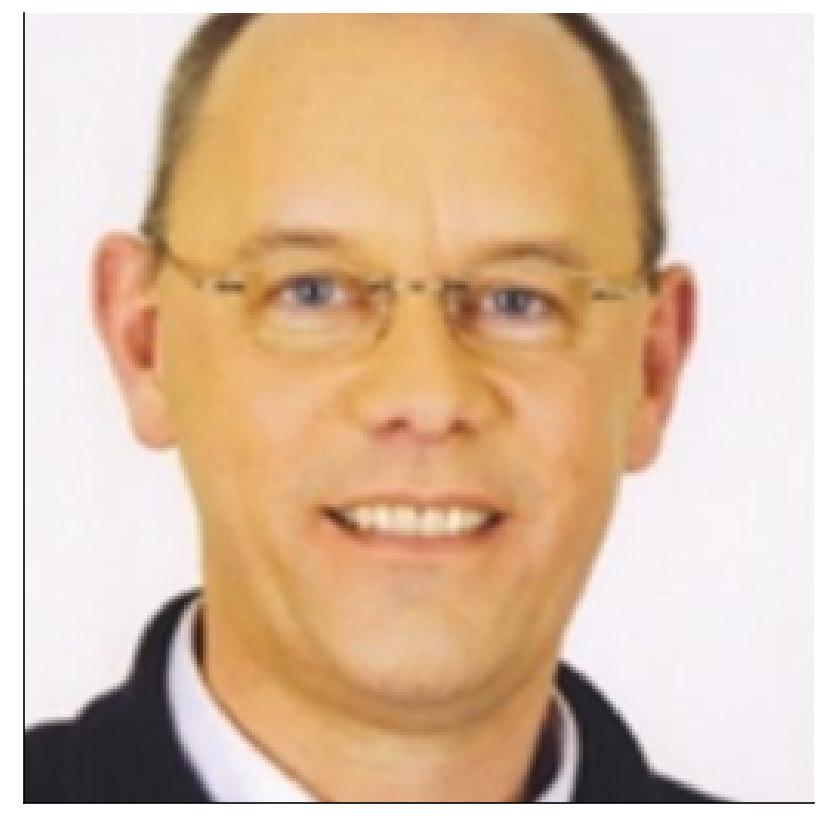

In [17]:
sample = train_dataset[0]
visualize_mtfl_sample(sample)

Can you interpret the above image and the labels corresponding to the image? Let's have a look at some more instances from the dataset.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D4_ContinualLearning/static/labels_cl.png">

## Section 2.2: Defining the model 

A typical multi-task model looks like below, with shared layers being layers where knowledge is shared. Task-specific layers, as the name suggests, are specific to the tasks. 

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D4_ContinualLearning/static/model_cl.png">


For the shared layers we will use a pre-trained backbone network. Here you can try out various models, we have provided an example of using resnet18 backbone. We have to remove the last fully connected layer, because that is specifically used for classificiation task. Futher, for each task we have some fully connected layers, you can play around with more layers on your own! 

### Coding Exercise 2.2: Creating a Multi-Task model

Complete the custom model class `Multi_task_model`. 
Complete the `forward()` function, by adding your solution to collect outputs for all the tasks using the fully connected for the corresponding task. 

You can find an entire list of pre-trained models provided by PyTorch [here](https://pytorch.org/vision/stable/models.html)

In [18]:
class Multi_task_model(nn.Module):
  def __init__(self, pretrained=True, num_tasks=4, load_file=None,
               num_labels_per_task=[2, 2, 2, 5]):
    super(Multi_task_model, self).__init__()
    self.backbone = models.resnet18(pretrained=pretrained)  # You can play around with different pre-trained models
    if load_file:
      self.backbone.load_state_dict(torch.load(load_file))
    self.backbone = torch.nn.Sequential(*(list(self.backbone.children())[:-1]))  # Remove the last fully connected layer

    if pretrained:
      for param in self.backbone.parameters():
        param.requires_grad = False

    self.fcs = []

    self.num_tasks = num_tasks

    for i in range(self.num_tasks):
      self.fcs.append(nn.Sequential(
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(128, num_labels_per_task[i]),
          ################################
          # Add more layers if you want! #
          ################################
          nn.Softmax(dim=1),
      ))

      self.fcs = nn.ModuleList(self.fcs)

  def forward(self, x):
    x = self.backbone(x)
    x = torch.flatten(x, 1)
    outs = []
    #################################################
    # Collect outputs for each task
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Complete the model!")
    #################################################
    for i in range(...):
      outs.append(...)
    return outs


# add event to airtable
atform.add_event('Coding Exercise 2.2: Creating a Multi-Task model')

In [19]:
# to_remove solution
class Multi_task_model(nn.Module):
  def __init__(self, pretrained=True, num_tasks=4, load_file=None,
               num_labels_per_task=[2, 2, 2, 5]):
    super(Multi_task_model, self).__init__()
    self.backbone = models.resnet18(pretrained=pretrained)  # You can play around with different pre-trained models
    if load_file:
      self.backbone.load_state_dict(torch.load(load_file))
    self.backbone = torch.nn.Sequential(*(list(self.backbone.children())[:-1]))  # Remove the last fully connected layer

    if pretrained:
      for param in self.backbone.parameters():
        param.requires_grad = False

    self.fcs = []

    self.num_tasks = num_tasks

    for i in range(self.num_tasks):
      self.fcs.append(nn.Sequential(
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(128, num_labels_per_task[i]),
          ################################
          # Add more layers if you want! #
          ################################
          nn.Softmax(dim=1),
      ))

      self.fcs = nn.ModuleList(self.fcs)

  def forward(self, x):
    x = self.backbone(x)
    x = torch.flatten(x, 1)
    outs = []
    for i in range(self.num_tasks):
      outs.append(self.fcs[i](x))
    return outs


# add event to airtable
atform.add_event('Coding Exercise 2.2: Creating a Multi-Task model')

To avoid any major blackout due to multiple downloads, we download a pretrained ResNet model locally.

**Note:** If `pretrained=False` and `load_file` exists, we load the pretrained model from a file. If you want to use a different model, set `load_file` to `None`.

In [20]:
# @title Download `resnet18` pretrained
url = "https://osf.io/2kd98/download"
fname = "resnet18-f37072fd.pth"
r = requests.get(url, allow_redirects=True)

with open(fname, 'wb') as fd:
  fd.write(r.content)

In [21]:
"""
Initialize two models with and without pre-trained weights
"""
model_with_pre_trained_backbone = Multi_task_model(pretrained=False,
                                                   load_file=fname).to(DEVICE)
model_without_pre_trained_backbone = Multi_task_model(pretrained=False).to(DEVICE)

Let's define the loss function and optimizer. Since this is a classification task, we will be using cross-entropy loss. For the optimizer we will be using Stochastic Gradient descent. 

In [22]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_without_pre_trained_backbone = optim.SGD(
    model_without_pre_trained_backbone.parameters(),
    lr=0.001,
    momentum=0.9
    )

optimizer_pre_trained_backbone = optim.SGD(
    model_with_pre_trained_backbone.parameters(),
    lr=0.001,
    momentum=0.9
    )

## Section 2.3: Training model without pretrained backbone

In [23]:
model_without_pre_trained_backbone = train_multi_task(
    model_without_pre_trained_backbone,
    train_loader,
    val_loader,
    criterion,
    optimizer_without_pre_trained_backbone,
    epochs=5, device=DEVICE
    )


======== Epoch 1 / 5 ========


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training => Avg. Task Accuracy: 0.6871875000000001
Validation => Avg. Task Accuracy: 0.698

======== Epoch 2 / 5 ========
Training => Avg. Task Accuracy: 0.711875
Validation => Avg. Task Accuracy: 0.71

======== Epoch 3 / 5 ========
Training => Avg. Task Accuracy: 0.7228125000000001
Validation => Avg. Task Accuracy: 0.7142499999999999

======== Epoch 4 / 5 ========
Training => Avg. Task Accuracy: 0.72865625
Validation => Avg. Task Accuracy: 0.7268749999999999

======== Epoch 5 / 5 ========
Training => Avg. Task Accuracy: 0.7357500000000001
Validation => Avg. Task Accuracy: 0.72375


## Section 2.4: Training model with pretrained backbone

In [24]:
model_pre_trained_backbone = train_multi_task(model_with_pre_trained_backbone,
                                              train_loader,
                                              val_loader,
                                              criterion,
                                              optimizer_pre_trained_backbone,
                                              epochs=5, device=DEVICE)


======== Epoch 1 / 5 ========
Training => Avg. Task Accuracy: 0.7608124999999999
Validation => Avg. Task Accuracy: 0.81725

======== Epoch 2 / 5 ========
Training => Avg. Task Accuracy: 0.82440625
Validation => Avg. Task Accuracy: 0.832375

======== Epoch 3 / 5 ========
Training => Avg. Task Accuracy: 0.8487500000000001
Validation => Avg. Task Accuracy: 0.835375

======== Epoch 4 / 5 ========
Training => Avg. Task Accuracy: 0.8635312500000001
Validation => Avg. Task Accuracy: 0.84

======== Epoch 5 / 5 ========
Training => Avg. Task Accuracy: 0.87221875
Validation => Avg. Task Accuracy: 0.8415


## Section 2.5: Section Summary

We can summarize this section as follows

* Transfer learning helps in initializing the model better and thus makes learning of the model faster. It also gives better performance compared to the same model that was trained from scratch. Below is a table which contains validation accuracies after 5 epochs (your accuracies can be slightly different when you run the training loops. It will also depend on the number of epochs and the model you have implemented)-


|           Method          | Validation Accuracy |
|:-------------------------:|:-------------------:|
|   With Transfer Learning  |      **0.779**      | 
| Without Transfer Learning |        0.728        |

* Multi-task learning helps us learn multiple tasks together, by sharing knowledge across layers. Task specific layers then help the model learn task specific features. 


---
# Section 3: Interpretability

In [25]:
# @title Video 3: Interpretability
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ey4y1j7Jj", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"P_QtnN1_wMM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Interpretability')

display(out)

Lets' find the most important feature for Cancer prediction and see if it belongs to the set of two most important features for the same problem!

## Section 3.1: Defining the problem setup

Imagine that you want to apply all the knowledge that you have gained from this course to a real health problem, say predicting cancer. You develop an algorithm for predicting cancer using certain input features from patient data. 

This is a composite model that takes in three binary variables: does the patient have a family history of cancer (1=yes, 0=no), does the patient smoke (1=yes, 0=no), and is the patient young (age < 40) (1=yes, 0=no).

The algorithm does not favour either of the outcomes, so $P(cancer) = P(no\_cancer) = .5$

You wish to find the most important feature according to the model and you have the following list of conditional probabilities.

<br>

\begin{align}
P(family\_history = 1  | no\_cancer) = .1 &, P(family\_history = 1 | cancer) = .9 \\
P(smoker = 1 | no\_cancer) = .05 &, P(smoker = 1| cancer) = .8 \\
P(young = 1 | no\_cancer) = .01 &, P(young = 1 | cancer) = .71
\end{align}

## Section 3.2: Defining a feature importance metric

Let's define a metric that can help us quantify how important a feature (or a given set of features) is!

### Think! 3.2.1: Think of a suitable feature importance metric!

Take a moment to think about feature importance and a simple metric for quantifying it! Remember that the feature importance should depend on how useful the feature is for predicting the outcome *alone*.

In [26]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Now discuss the following with the group: 

1. Each member of the group should briefly talk about the feature metric they came up with and why they think it is suitable for the given problem setup.
2. Identify the most important characterics of a good feature importance metric. (As different members of the group used different criteria to select their metrics, find out the most important criteria that helped!). Try to limit yourself to the two most important characteristics. 

Note down the most important characteristic here!

In [27]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type the most important characteristic and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type the most important characteristic and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Also note down the second most important characteristic here.

In [28]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type the second most important characteristic and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type the second most important characteristic and click on `Submit!`', placeholder='Type somet…

Button(description='Submit!', style=ButtonStyle())

Thank you for coming up with some guidelines for what makes a feature importance metric good!

Although the metrics defined by you must be great, we here define a simple metric for maintaining consistency throughout the rest of this tutorial.

Let's assume that we wish to find the K best features. We know that a set of K features would be most important if they can predict the outcome with high confidence and better than any other set of the same size! We could hence try to predict the outcome using only the given set of features and record the accuracy. If this accuracy is higher than that using any other set of the same size, then we can say that the given set has the most important K features!

In essence, we would want to find the accuracies considering all feature sets of size K and then pick the one with the highest accuracy.

If we wish to define a loss instead (the lower the better), we could simply extend the above notion as follows:

\begin{equation}
Loss = 1 - Accuracy
\end{equation}

### Think! 3.2.2: Is our feature importance metric good?

Now that we have provided a new feature importance metric, think of the following: 

1. What do you think of this new feature importance metric, and how is it different from the one that you came up with? 
2. Does it satify the criteria that you came up with? 
3. If not, why? Does the metric need to be modified or the criteria?

In [29]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q4' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

## Section 3.3: Finding the most important feature

Considering the feature importance metric that we defined above, let's try to find the most important and the two most important features!

The accuracy can be calculated using the probabilities specified above. Here are the accuracies for different feature sets! (Note that we have not detailed the calculation of these accuracies. If you are curious, refer to the bonus section!)

For a detailed explanation, see *Bonus 3*.

|           Feature(s)          | Accuracy |
|:---------------------------:|:-------------------:|
|   Family History            |        0.90         | 
| Is a Smoker                 |        0.875        |
| Is Young                    |        0.85         |
| Family History, Is a Smoker |        0.917        |
| Is a Smoker, Is Young       |        0.941        |
| Family History, Is Young    |        0.931        |


### Think! 3.3.1: Finding important features

Given the table above, what is the single most important feature?

In [30]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q5' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [31]:
# to_remove explanation

"""
Answer: Family History

Why?

The most important feature would be the one which gives the highest accuracy
when used alone. This makes Family History the most important feature using it
alone results in an accuracy of 0.9 as opposed to 0.875 and 0.85 when using
`Is_a_smoker` and `Is_young`, respectively
""";

Can you also find out the second most important features?

In [32]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q6' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [33]:
# to_remove explanation

"""
Answer: Is a Smoker and Is Young
""";

The most important feature is not one of the two most important features! Can you find out why this is the case?

## Section 3.4: Section Summary

In this section, we discussed the following:

* What is Interpretability and why is it important?

* How can input features be used to understand the model's predictions (aka feature importances)? 


---
# Summary

Recall the problem that you set out to solve at the beginning of this tutorial.

In [34]:
# @markdown *Run me to print the problem that you wanted to solve!*
print(Problem_that_you_want_to_solve)

Take a moment to think about the following:

1. Did this tutorial help you find some ideas to solve this problem?
2. Can you now come up with a solution to this problem by using all the tools that you learnt from this course?

We sincerely hope that your answers to these two questions are yes and YES! Recall all that you learnt from this course and how this knowledge and practical experience can help with a problem that *you* want to solve. Go back and experiment with your solutions and see if you can solve this problem that matters to you!    

In [35]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus 1: Introduction to Meta Learning

*Time estimate: ~20mins*

In this section, we will *literally* learn to learn by exploring the concept of Meta Learning. Meta Learning attempts to improve the generalization capabilities of neural networks by teaching them *how to learn new tasks fast*. We aim to introduce you to the following topics:

1. Meta-Learning and its applications 
2. Few-shot classification (the most common application of Meta-Learning in supervised classification settings)
3. One-shot Learning with Convolutional Siamese Networks

In [36]:
# @title Video 4: Meta Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1zU4y1n77d", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"8grBwtrzcDI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Meta Learning')

display(out)

Meta-Learning is most commonly observed as Few-shot Learning in Supervised learning settings.

Few-shot Learning aims to answer the following question: How can a neural network learn a task well with *very little* data? 

In the context of supervised classification, K-shot learning refers to learning with only K examples of each class. An extension of this would be N-way K-shot learning, which attempts to train a network with only K examples of each of the N classes. Let's take an example of a 5-way 1-shot problem: 

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D4_ContinualLearning/static/Metalearning.png">

Now that we know what Few-shot learning is, let's take a look at a One-shot classification problem using Siamese Networks!

## Bonus Section 1.1: Introduction to Omniglot

The Omniglot data set is a a standardized benchmark for evaluating the performance of Few-shot Learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. The alphabets range from well-established international languages like Latin and Korean to lesser known local dialects. Fictitious character sets such as Aurek-Besh and Klingon are also included. Here are a few examples from the Omniglot dataset.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D4_ContinualLearning/static/omni.jpeg.png">

## Bonus Section 1.2: Convolutional Siamese Networks

The simplest way to evaluate where an image belongs to a class is by comparing it with other images of the same class. Convolutional Siamese networks help us in comparing two images and quantify how similar or different they are from one another. This is known as verification.

Verification of two images is done as follows: Both the images are passed through the convolutional network to generate *feature vectors* representing them. These feature vectors are then compared for similarity. (Find a better image for siamese network maybe)


<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D4_ContinualLearning/static/siamese.png">


How can we compare if two vectors are similar? By using a distance metric! **L1 distance** is one such metric that evaluates the distance between two vectors by computing the absolute value of the difference of invidual components of both vectors. More specifically, given vectors `v1` and `v2`, the component-wise L1 distance would be as follows:

```
l1_distance = abs(v1 - v2)
```

After this, the problem boils down to a binary classification problem where two images either belong to the same class or not!

### Bonus Coding Exercise 1.2: Creating a Convolutional Siamese Network

Let's create a Convolutional Siamese Network! The structure of the network is created in the `ConvSiameseNet` class. You have to compute the L1 distance (`l1_distance`) between the feature vectors (`x1_fv` and `x2_fv`). You can use `torch.abs()` to compute the absolute value of a tensor.

In [37]:
# Define the Siamese Network
class ConvSiameseNet(nn.Module):
  """
  Convolutional Siamese Network from "Siamese Neural Networks for One-shot Image Recognition"
  Paper can be found at http://www.cs.toronto.edu/~rsalakhu/papers/oneshot1.pdf
  """

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128, 128, 4)
    self.conv4 = nn.Conv2d(128, 256, 4)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(256*6*6, 4096)
    self.fc2 = nn.Linear(4096, 1)

  def model(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = F.relu(self.conv4(x))
    x = torch.flatten(x, 1)
    x = torch.sigmoid(self.fc1(x))
    return x

  def forward(self, x1, x2):
    x1_fv = self.model(x1)
    x2_fv = self.model(x2)
    ############################################################################
    ## TODO: Calculate the component-wise l1_distance between x1_fv and x2_fv ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: Calculate l1_distance")
    ############################################################################
    # Calculate L1 distance (as l1_distance) between x1_fv and x2_fv
    l1_distance = ...

    return self.fc2(l1_distance)

In [38]:
# to_remove solution
# Define the Siamese Network
class ConvSiameseNet(nn.Module):
  """
  Convolutional Siamese Network from "Siamese Neural Networks for One-shot Image Recognition"
  Paper can be found at http://www.cs.toronto.edu/~rsalakhu/papers/oneshot1.pdf
  """

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128, 128, 4)
    self.conv4 = nn.Conv2d(128, 256, 4)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(256*6*6, 4096)
    self.fc2 = nn.Linear(4096, 1)

  def model(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = F.relu(self.conv4(x))
    x = torch.flatten(x, 1)
    x = torch.sigmoid(self.fc1(x))
    return x

  def forward(self, x1, x2):
    x1_fv = self.model(x1)
    x2_fv = self.model(x2)
    # Calculate L1 distance (as l1_distance) between x1_fv and x2_fv
    l1_distance = torch.abs(x1_fv - x2_fv)

    return self.fc2(l1_distance)

## Bonus Section 1.3: Verification using Siamese Networks

Let's train the siamese network we created on verification of images. We'll take pairs of images from the Omniglot dataset and train the network to identify if the pairs belong to the same class or not.

Let's first get the Omniglot dataset with pairs of images. A pair is labelled "1" if the images are of the same character, and "0" otherwise.

In [39]:
# @title Download Omniglot dataset with pairs
import zipfile, os, requests

# original location: https://github.com/brendenlake/omniglot/tree/master/python
os.chdir(CWD)
print(f'Change dir: {os.getcwd()}')

dirname = 'data/omniglot-py/'
if not os.path.exists(dirname):
  os.makedirs(dirname)

fname = 'images_background.zip'
url = "https://osf.io/6hq9u/download"

if not os.path.exists(dirname + 'images_background'):
  print('Downlading the dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(dirname + fname, 'wb') as fd:
    fd.write(r.content)
  with zipfile.ZipFile(dirname + fname, 'r') as zip_ref:
    zip_ref.extractall(dirname)
  print('Dataset is downloaded.')
else:
  print('Dataset has already been downloaded.')

Change dir: /content
Downlading the dataset...
Dataset is downloaded.


In [40]:
"""
Load train and validation datasets for training the Siamese Network
"""

train_dataset, val_dataset = get_train_val_datasets(background_dataset_size=10000, val_split=0.2, download=False)

-------------------- Label: 1.0 (Same character) -------------------


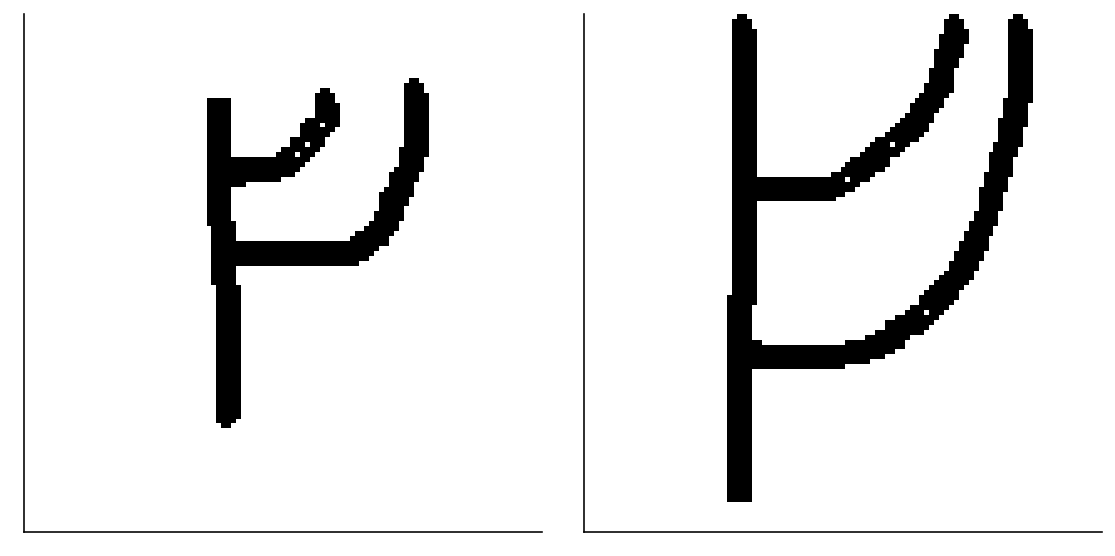

In [41]:
"""
Visualize a sample from the training dataset
"""

# Change this to visualize another sample from the dataset
sample_idx = 1
sample = train_dataset[sample_idx]

visualize_siamese_sample(sample)

In [42]:
"""
Create dataloaders for the train and validation datasets
"""

# Change this for a different batch size
batch_size = 16

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g_seed
    )

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g_seed
    )

Now that we have the necessary dataloaders, let's train a siamese network! 

In [43]:
"""
Train the network on Omniglot
"""

siamese_net = ConvSiameseNet()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.0001)

# Change this to train for any number of epochs
num_epochs = 10

for epoch in range(num_epochs):
  print(f"\n Epoch {epoch + 1} / {num_epochs} ================================")

  train_siamese_network(siamese_net, criterion, optimizer, train_loader, DEVICE)
  evaluate_siamese_network(siamese_net, criterion, val_loader, DEVICE)


 Epoch 1 / 10 ================================
Training => Average Loss: 0.5724533715844154 | Accuracy: 0.6798750162124634
Validation => Average Loss: 0.5259384648799896 | Accuracy: 0.718000054359436

 Epoch 2 / 10 ================================
Training => Average Loss: 0.48884776774048805 | Accuracy: 0.7630000114440918
Validation => Average Loss: 0.44740152621269225 | Accuracy: 0.796000063419342

 Epoch 3 / 10 ================================
Training => Average Loss: 0.4120025425106287 | Accuracy: 0.8186250329017639
Validation => Average Loss: 0.3629732095003128 | Accuracy: 0.8445000648498535

 Epoch 4 / 10 ================================
Training => Average Loss: 0.33907638520002364 | Accuracy: 0.8595000505447388
Validation => Average Loss: 0.31162960731983186 | Accuracy: 0.8740000128746033

 Epoch 5 / 10 ================================
Training => Average Loss: 0.30186013962328434 | Accuracy: 0.8816250562667847
Validation => Average Loss: 0.29580460506677625 | Accuracy: 0.880

## Bonus Section 1.4: One-shot Classification with Siamese Networks

Now that we have a siamese network trained on verification, let's try to extend it to one-shot classification. How can we do this? 

Let's first try to understand what the current network offers: Given two images, find out if they belong to the same class or not. 

What does N-way one-shot classification ask for? Given one image from each of the N classes (the support set), find out which class does the query image belong to.

Take a moment to think about how the verification network can be extended to work in the one-shot setting.

Given a query image, compare it with different images in the support set using our siamese network. Pick the class that is most similar to the query image!

Let's get the test dataset where one sample corresponds to a query image and N support images!

In [44]:
# @title Download the test dataset
import zipfile, os, requests

# original location: https://github.com/brendenlake/omniglot/tree/master/python

dirname = 'data/omniglot-py/'
if not os.path.exists(dirname):
  os.makedirs(dirname)

fname = 'images_evaluation.zip'
url = "https://osf.io/uq4gw/download"

if not os.path.exists(dirname + 'images_evaluation'):
  print('Downlading the dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(dirname + fname, 'wb') as fd:
    fd.write(r.content)
  with zipfile.ZipFile(dirname + fname, 'r') as zip_ref:
    zip_ref.extractall(dirname)
  print('Dataset is downloaded.')
else:
  print('Dataset has already been downloaded.')

Downlading the dataset...
Dataset is downloaded.


In [45]:
"""
Load the test dataset for N-way One-shot classification
"""

# Change this to change the number of classes in the support set
n_ways = 5

test_dataset = get_test_dataset(n_ways=n_ways, download=True)

Files already downloaded and verified


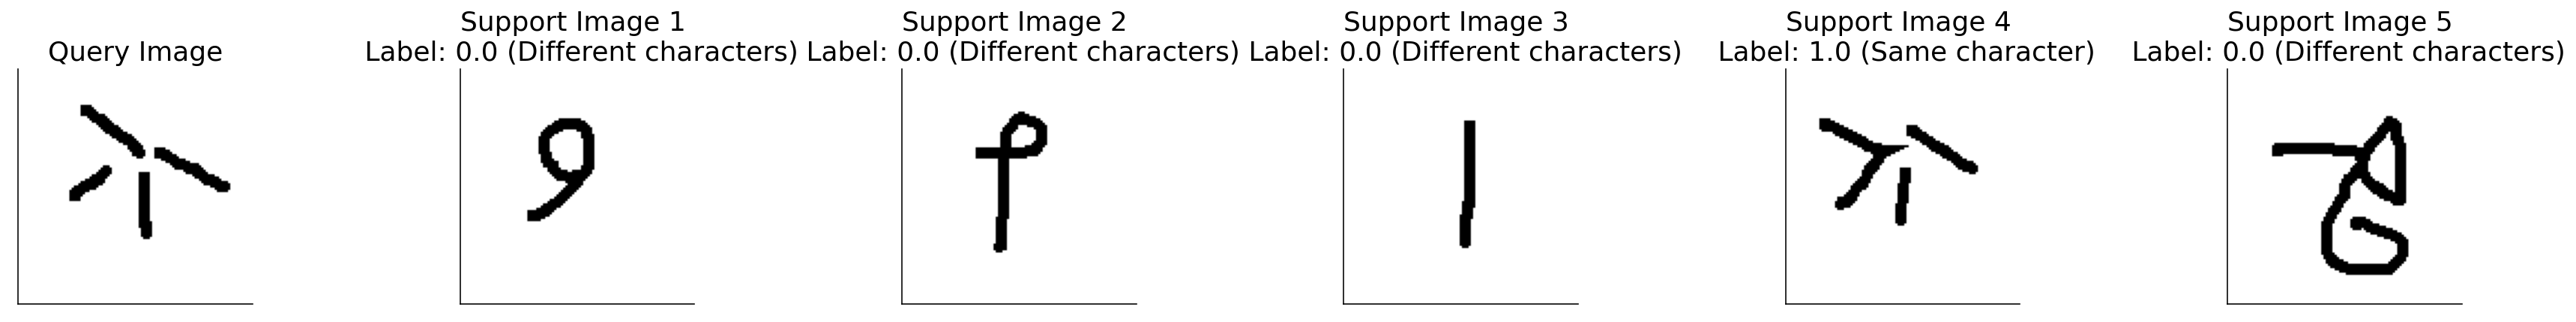

In [46]:
"""
Visualize a sample from the test dataset
"""

# Change this to visualize another sample from the dataset
sample_idx = 1
sample = test_dataset[sample_idx]

visualize_one_shot_sample(sample)

We are in the endgame now. Let's look at how our siamese network performs on N-way One-shot classification!

In [47]:
"""
Evaluate our Siamese Network on N-way One-shot classification
"""

batch_size = 16

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g_seed
    )

evaluate_one_shot(siamese_net, test_loader, DEVICE)

Testing (One-shot) => Accuracy: 0.8442336916923523


Congratulations! We successfully solved our first Meta-Learning problem. Feel free to run through this section again with different parameters and compare the differences!

## Bonus Section 1.5: Section Summary

In this section, we learnt the following (try to answer these questions to ensure that you understood the content fairly well):

* What is Meta-Learning and how is it used to solve various problems with Deep Learning?

* What is Few-shot Learning? We took a look at what is N-way K-shot classification using the Omniglot dataset and Convolutional Siamese Networks.


---
# Bonus 2: Continual and Life-Long Learning

In [48]:
# @title Video 5: Continual and Life-Long Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1uX4y1c7Yh", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"-lmY_lc75As", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Continual and Life-Long Learning')

display(out)

## Bonus Think! 2: Why are Continual and Life-Long Learning tough?

Take a moment to think about the following:

1. You have had an extensive tutorial on Continual Learning. Can you quickly recall the different problems with Continual Learning and how these problems were solved?
2. What do you think makes Life-Long Learning tough to implement? How is this learning paradigm different from those that you have seen before? 

---
# Bonus 3 - Feature Importance Tutorial

If you wish to understand how the accuracies are calculated in Section 3.3, continue reading!

Recall the problem setup:

There exist binary-valued random variables $X^{(1)}, X^{(2)}, X^{(3)}, Y \in {0,1}$ such that $X^{(1)}, X^{(2)}$, and $X^{(3)}$ are conditionally independent (given $Y$).

Let $P(Y=1) = 1/2$. Then the joint distribution of $X^{(1)}, X^{(2)}, X^{(3)}, Y$ is specified by the conditional probabilities $P(X_i=1 | Y=0)$ and $P(X_i=1 | Y=1)$, for $i=1,2,3$:

\begin{align}
P(X^{(1)}=1|Y=0)=0.10 &, P(X^{(1)}=1|Y=1)=0.0.90 \\
P(X^{(2)}=1|Y=0)=0.05 &, P(X^{(2)}=1|Y=1)=0.0.80 \\
P(X^{(3)}=1|Y=0)=0.01 &, P(X^{(1)}=1|Y=1)=0.0.71
\end{align}

## Define a feature importance metric

Here we'll use 0-1 loss to define feature importance. We can imagine using $X^{(1)}, X^{(2)}$, and $X^{(3)}$ to predict $Y$. $Y$ can only be 0 or 1, so your predictions must be 0 or 1 and will either be right or wrong (i.e, perfect for 0-1 loss).

## Calculate the individual feature importance (0-1 loss) for  $X^{(1)}$, $X^{(2)}$, and $X^{(3)}$

**Hint:** You can accomplish this by finding the probability that  X  and  Y  match. You're given $P(X^{(1)}=1|Y=0)$, but you need $P(X^{(1)}=0|Y=0)$ . Recall that $P(Y)=1/2$ and compute an equally weighted average of the two accuracies you can compute given the two possible values of $X^{(1)}$ .

**Solution:** If $P(X^{(1)} = 1|Y = 0)=0.10$, then $P(X^{(1)} = 0|Y = 0)=0.90$. 

There's a symmetry we can take advantage of here: we know that 90% of the time $Y=1$ we have $X=1$, which implies that 90% of the time $X=1$ we have $Y=1$, which is a more natural way of thinking about prediction.

This means we predict correctly 90% of the time when $Y=0$, and we predict correctly 90% of the time when $Y=1$. Since $P(Y)=1/2$, we have 0-1 loss $L = 1-(0.5 \times 0.9 + 0.5 \times 0.9)=0.1$.

In total, we have:

\begin{align}
L_1 =& 1 - (0.5 \times 0.9 + 0.5 \times 0.9) = 0.1 \\
L_2 =& 1 - (0.5 \times 0.95 + 0.5 \times 0.8) = 0.125 \\
L_3 =& 1 - (0.5 \times 0.99 + 0.5 \times 0.71) = 0.15.
\end{align}

**Check:** If you did not observe that feature $X^{(1)}$ is the most important feature by virtue of having the smallest 0-1 loss (0.1), check your calculations before proceeding.

### Calculate the importance of feature pairs (0-1 loss) for $\{X^{(1)}, X^{(2)}\}$, $\{X^{(1)}, X^{(3)}\}$, and $\{X^{(2)}, X^{(3)}\}$




### Let's start with $\{X^{(1)}, X^{(2)}\}$

Working out these calculations is a bit tedious, so we'll provide various tables and descriptions of their origins.

First, we compute conditional PMFs $P\left( X^{(1)}, X^{(2)}∣Y \right)$ by multiplying the provided conditionally independent probabilities together.

**Conditional PMFs:**

| $P(X_1,X_2|Y=0)$ |$X_2=0$  |$X_2=1$ |
|------------------|---------|--------|
| $X_1=0$          | 0.855   | 0.045  |
| $X_1=1$          | 0.095   | 0.005  |

<br>

| $P(X_1,X_2|Y=1)$ |$X_2=0$  |$X_2=1$ |       
|------------------|---------|--------|
| $X_1=0$          | 0.02    | 0.08   |
| $X_1=1$          | 0.18    | 0.72   |


We can then obtain a marginal PMF for $\{X^{(1)}, X^{(2)}\}$ by element-wise averaging these two 2x2 tables because $P(Y)=1/2$.

**Marginal PMF:**

| $P(X_1,X_2)$ |$X_2=0$  |$X_2=1$ |       
|--------------|---------|--------|
| $X_1=0$      | 0.4375  | 0.0625 |       
| $X_1=1$      | 0.1375  | 0.3625 |


We now use the conditional PMFs to evaluate the conditional probability expressions we care about: $P\left( Y∣X^{(1)}, X^{(2)} \right)$.

<br>

**Conditional Probabilities: $P \left( Y=\{0, 1\}|X_1,X_2 \right)$**

<br>

\begin{equation}
\frac{P(X_1,X_2 | Y=0)}{P(X_1,X_2|Y=0) + P(X_1,X_2|Y=1)}
\end{equation}

<br>

| $P(Y=0|X_1,X_2)$ |$X_2=0$   |$X_2=1$   |
|------------------|----------|----------|
| $X_1=0$          | 0.977143 | 0.36     |
| $X_1=1$          | 0.345455 | 0.006897 |


\begin{equation}
\frac{P(X_1, X_2 | Y=1)}{P(X_1,X_2|Y=0) + P(X_1,X_2|Y=1)}
\end{equation}

<br>

| $P(Y=1|X_1,X_2)$ |$X_2=0$    |$X_2=1$   |
|------------------|-----------|----------|
| $X_1=0$          | 0.022857  | 0.64     |
| $X_1=1$          | 0.654545  | 0.993103 |

<br>

We now implement a 0-1 classifier that predicts $\hat{Y}=0$ or $\hat{Y}=1$ based on the element-wise maximum in these two tables. For example, when $X^{(1)}=0$ and $X^{(2)}=0$, there's a 0.977 probability that $Y=0$ and a 0.023 probability that $Y=1$. We would of course predict $\hat{Y}=1$ , and we expect to be correct 97.7% of the time.

We now know the expected probability of success for our classifier for each $\{X^{(1)}, X^{(2)}\}$ combination.

<br>

**Maximum Conditional Probability:**

| $P(\text{Correct}|X_1,X_2)$ |$X_2=0$   |$X_2=1$   |
|-----------------------------|----------|----------|
| $X_1=0$                     | 0.977143 | 0.64     |
| $X_1=1$                     | 0.654545 | 0.993103 |


Only one task remains for you to complete: compute the expected 0-1 loss for this classifier.

<br>

**Hint:** We know how likely we are to be correct given some $\{X(1), X(2)\}$ combination. We also know how likely those combinations are to appear.

**Solution:**

In [49]:
marginal = np.array([[0.4375, 0.0625],
                     [0.1375, 0.3625]])
max_cond_prob = np.array([[0.977, 0.64],
                          [0.6545, 0.993]])
# We need the sum-product of these two arrays.
# (1) element-wise multiplication to produce one array.
# (2) sum the elements of the resulting array
accuracy = np.sum(np.multiply(marginal, max_cond_prob))
print(accuracy)

0.9173937499999999


In [50]:
# 0-1 loss is 1 - accuracy.
print(1 - accuracy)

0.0826062500000001


**Check:** You should have gotten 0-1 loss for $\{X^{(1)}, X^{(2)}\}$ to be 0.0826.

### Let's move on to  $\{X^{(2)}, X^{(3)}\}$

Our claim was that the most important single feature, already found to be $\{X^{(1)}$\}, is not in the most important pair of features, so we just need to show that the 0-1 loss for $\{X^{(2)}, X^{(3)}\}$ is less than 0.0826.

First, we compute conditional PMFs $P \left( X^{(2)}, X^{(3)}∣Y \right)$ by multiplying conditionally independent probabilities together.

**Conditional PMFs:**

| $P(X_2,X_3|Y=0)$ |$X_3=0$  |$X_3=1$ |
|------------------|---------|--------|
| $X_2=0$          | 0.9405  | 0.0095 |
| $X_2=1$          | 0.0495  | 0.0005 |

| $P(X_2,X_3|Y=1)$ |$X_3=0$  |$X_3=1$ | 
|-----------------|---------|--------|
| $X_2=0$          | 0.058   | 0.142  |
| $X_2=1$          | 0.232   | 0.568  |

We can then obtain a marginal PMF for $\{X^{(2)}, X^{(3)}\}$ by element-wise averaging these two 2x2 tables because $P(Y)=1/2$.


**Marginal PMF:**

| $P(X_2,X_3)$   |$X_3=0$    |$X_3=1$  |
|----------------|-----------|---------|
| $X_2=0$        | 0.49925   | 0.07575 |
| $X_2=1$        | 0.14075   | 0.28425 |


We now use the conditional PMFs to evaluate the conditional probability expressions we care about: $P \left( Y∣X^{(2)}, X^{(3)} \right)$.

<br>

**Conditional Probabilities: $P \left( Y=\{0, 1\}|X_2, X_3 \right)$**

<br>

\begin{equation}
\frac{P(X_2,X_3 | Y=0)}{P(X_2, X_3|Y=0) + P(X_2, X_3|Y=1)}
\end{equation}

<br>

| $P(Y=0|X_2,X_3)$ | $X_3=0$     |$X_3=1$      |   
|------------------|-------------|-------------|
| $X_2=0$          | 0.941912869 | 0.062706271 |
| $X_2=1$          | 0.175843694 | 0.000879507 |


\begin{equation}
\frac{P(X_2,X_3 | Y=1)}{P(X_2, X_3|Y=0) + P(X_2, X_3|Y=1)}
\end{equation}

<br>

| $P(Y=0|X_2,X_3)$ | $X_3=0$     |$X_3=1$      |   
|------------------|-------------|-------------|
| $X_2=0$          | 0.058087131 | 0.937293729 |
| $X_2=1$          | 0.824156306 | 0.999120493 |

<br>

We now implement a 0-1 classifier that predicts $\hat{Y}=0$ or $\hat{Y}=1$ based on the element-wise maximum in these two tables. For example, when $X^{(2)}=0$ and $X^{(3)}=0$, there's a 0.942 probability that $Y=0$ and a 0.058 probability that $Y=1$. We would of course predict $\hat{Y}=1$ , and we expect to be correct 94.2% of the time.

We now know the expected probability of success for our classifier for each $\{X^{(2)}, X^{(3)}\}$ combination.

<br>

**Maximum Conditional Probability:**

| $P(\text{Correct}|X_2,X_3)$ |$X_3=0$      |$X_3=1$      |
|-----------------------------|-------------|-------------|
| $X_1=0$                     | 0.941912869 | 0.937293729 |
| $X_1=1$                     | 0.824156306 | 0.999120493 |


Only one task remains for you to complete: compute the expected 0-1 loss for this classifier.

<br>

**Hint:** We know how likely we are to be correct given some $\{X(2), X(3)\}$ combination. We also know how likely those combinations are to appear.

**Solution:**

In [51]:
marginal = np.array([[0.49925, 0.07575],
                     [0.14075, 0.28425]])
max_cond_prob = np.array([[0.941912869, 0.937293729],
                          [0.824156306,0.999120493]])
# We need the sum-product of these two arrays.
# (1) element-wise multiplication to produce one array.
# (2) sum the elements of the resulting array
accuracy = np.sum(np.multiply(marginal, max_cond_prob))
print(accuracy)

0.9412500000247499


In [52]:
# 0-1 loss is 1 - accuracy.
print(1 - accuracy)

0.0587499999752501


**Check:** You should have gotten 0-1 loss for $\{X^{(2)}, X^{(3)}\}$ to be 0.05875.

## Conclusion

We demonstrated that our intuition could be misleading - it's not always the case that a feature that ranks highly among individual features would necessarily warrant being included at all when larger sets of features are considered.

Something to think about: What does this tell you about stepwise feature selection approaches?